# Instala dependências

In [1]:
%pip install graphviz
%pip install pydotplus

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\users\vitor\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\vitor\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


In [2]:
#basics
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#text process
import nltk
import unidecode
import string
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

# Classification
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Decision tree
import graphviz
import pydotplus
from sklearn.tree import DecisionTreeClassifier,export_graphviz

# Introdução

Atualmente com o advento das redes sociais diversos desastres da humanidade são narrados em redes sociais
porém nem sempre os fatos aprensentados nas redes sociais são veridicos e condizem com a realizade. Uma rede social
com alto nível de disseminação de informações é o Twitter, nele as pessoas conseguem passar informações sem nenhuma regra
(a não ser a limitação de caracteres) e fazendo posts na hora que quiserem, no Twitter publicações normalmente são chamados
de tweets. Neste contexto, tweets podem conter informações uteis para serviços de emergencia e para alertar as pessoas.
Assim este trabalho visa investigar tweets de desastres atraves de uma analise textual tentar descobrir se a informação é
veridica ou não.

# Definiçao do problema

O problema a ser resolvido é uma classificação binaria de um tweet sobre um desastre que ocorreu, a tarefa é analisar o
texto e tentar diferencias se é sobre um desastre real ou um que nunca existiu. Podemos ver um exemplo de tweet abaixo.

In [39]:
from IPython.display import Image

Image(url= "https://storage.googleapis.com/kaggle-media/competitions/tweet_screenshot.png", width=250, height=500)

# Descrição do conjunto de dados

O conjunto de dados foi extraido de uma competição da plataforma kaggle e pode ser encontrado nesse dominio :
https://www.kaggle.com/c/nlp-getting-started/overview

O dataset é composto por 5 colunas sendo elas:

<ul>
<li><b>Id</b> - Linha do tweet no data set</li>

<li><b>Keyword</b> - Palavra principal do texto do tweet, a maioria é vazia, então não usaremos como feature</li>

<li><b>Location</b> - Local onde o tweet foi realizado, tambem tem a maioria das entradas vazia então não usaremos como features</li>

<li><b>Text</b> - Texto do tweet de desastre, focaremos nele pois durante o curso aprendemos metodos para fazer analise textual</li>

<li><b>Target</b> - Target é a classe do tweet, 0 significa que não é sobre um desastre real e 1 significa que se trata
de um desastre real.</li>

</ul>

# Metodologia

## Processamento dos dados

Para realizar uma metodologia que faz sentido precisamos seguir alguns passos padrões tanto como a separação do dataset,
como gerar uma analise textual atraves da matriz TF-IDF e redução da dimensionalidade com PCA.


In [3]:
with open('./data/dataset.csv', encoding="utf8") as file:
    df = pd.read_csv(file)
    
df.head()



,id,keyword,location,text,target
0,0,NaN,NaN,Just happened a terrible car crash,0
1,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
2,2,NaN,NaN,"Heard about #earthquake is different cities, s...",0
3,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",0
4,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1


In [4]:
df.text = [c.lower() for c in df.text]


## Separação treino e teste

Ocorre a separação do dataset em treino em teste na proporção 80% pra 20%, respectivamente, além disso, a criação dos mesmo é feito de forma aleatória para não criarmos dataset enviesados, além de estar estratificado com o dataset.

In [5]:
from sklearn.model_selection import train_test_split

df_train_raw, df_test_raw = train_test_split(df, test_size=0.2, shuffle=True, random_state=42, stratify=df['target'])

df_train_raw = df_train_raw.sort_values(by=['id']).reset_index(drop=True)
df_test_raw = df_test_raw.sort_values(by=['id']).reset_index(drop=True)

df_train_raw = df_train_raw

## Trainset

In [6]:
print(df_train_raw.shape)
df_train_raw.head()

(8700, 5)


,id,keyword,location,text,target
0,0,NaN,NaN,just happened a terrible car crash,0
1,1,NaN,NaN,our deeds are the reason of this #earthquake m...,1
2,2,NaN,NaN,"heard about #earthquake is different cities, s...",0
3,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",0
4,4,NaN,NaN,forest fire near la ronge sask. canada,1


[Text(0, 0, 'Non Desaster'), Text(1, 0, 'Desaster')]

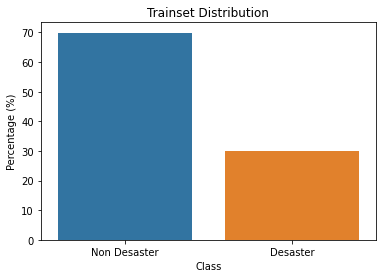

In [7]:
ax = sns.barplot(x='target', y='target',data = df_train_raw, estimator=lambda  x: len(x)/len(df_train_raw)*100)

ax.set_title('Trainset Distribution')
ax.set_ylabel('Percentage (%)')
ax.set_xlabel('Class')
ax.set_xticklabels(["Non Desaster","Desaster"])

## Testset

In [8]:
print(df_test_raw.shape)
df_test_raw.head()

(2176, 5)


,id,keyword,location,text,target
0,9,NaN,NaN,apocalypse lighting. #spokane #wildfires,0
1,11,NaN,NaN,typhoon soudelor kills 28 in china and taiwan,0
2,12,NaN,NaN,we're shaking...it's an earthquake,0
3,24,NaN,NaN,i love fruits,0
4,31,NaN,NaN,this is ridiculous....,0


[Text(0, 0, 'Non Desaster'), Text(1, 0, 'Desaster')]

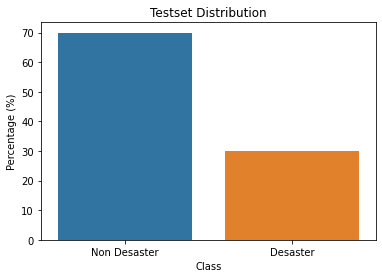

In [9]:
ax = sns.barplot(x='target', y='target',data = df_test_raw, estimator=lambda  x: len(x)/len(df_test_raw)*100)

ax.set_title('Testset Distribution')
ax.set_ylabel('Percentage (%)')
ax.set_xlabel('Class')
ax.set_xticklabels(["Non Desaster","Desaster"])

## O impacto dos Hashtags nos tweets

In [10]:
def findHashtags(text: str):
    return [tag.strip("#") for tag in text.split() if tag.startswith("#")]

df_train_raw['hashtags'] = df_train_raw.text.copy()
df_train_raw['hashtags'] = df_train_raw['hashtags'].apply(findHashtags)

df_test_raw['hashtags'] = df_test_raw.text.copy()
df_test_raw['hashtags'] = df_test_raw['hashtags'].apply(findHashtags)

## Estudo da distribuição dos hashtags

In [11]:
hashtags_train = set()
for i in df_train_raw.hashtags:
    for j in i:
        hashtags_train.add(j)
hashtags_test=set()
for i in df_train_raw.hashtags:
    for j in i:
        hashtags_test.add(j)

### Ocorrencias de hashtag no conjunto de treino

In [12]:
m={}
for i in range(df_train_raw.shape[0]):
    for j in df_train_raw.hashtags[i]:
        if df_train_raw['target'][i]:
            if(j not in m):
                m[j]=df_train_raw['target'][i]
            else:
                m[j]+=df_train_raw['target'][i]

# Sort the freq dict
freq_hashtags = {k: v for k, v in reversed(sorted(m.items(), key=lambda item: item[1]))}
print(freq_hashtags)

{'news': 42, '???': 18, 'hiroshima': 18, '??': 16, 'earthquake': 16, 'best': 10, 'prebreak': 10, 'hot': 10, 'japan': 10, 'india': 9, 'sismo': 8, 'world': 8, 'terrorism': 7, 'islam': 7, 'abstorm': 7, 'worldnews': 7, 'fukushima': 6, 'wx': 6, 'yyc': 6, 'rohingya': 6, 'wildfire': 6, 'isis': 5, 'bestnaijamade:': 5, 'nuclear': 5, 'africa': 5, 'okwx': 5, 'sittwe': 5, 'myanmar': 5, 'cnn': 5, 'breaking': 5, 'wildfires': 5, 'photography': 4, 'japì_n': 4, 'somalia': 4, 'sandiego': 4, 'bbc': 4, 'libya': 4, 'hostages': 4, 'hailstorm': 4, 'phoenix': 4, 'wmata': 4, 'mh370': 4, '\x89û_': 4, 'science': 3, 'idfire': 3, 'thunderstorm': 3, 'usnwsgov': 3, 'lies': 3, 'quran': 3, 'god': 3, 'truth': 3, 'gabon': 3, 'nytimes': 3, 'antioch': 3, 'guillermo': 3, 'hurricane': 3, 'bjp': 3, 'tdp': 3, 'trs': 3, 'nri': 3, 'ts': 3, 'ap': 3, 'iran': 3, 'boston': 3, 'arwx': 3, 'pakistan': 3, 'socialnews': 3, 'casper': 3, 'atlanta': 3, 'miami': 3, 'koin6news': 3, 'solar': 3, 'emergency': 3, 'drought': 3, 'genocide;': 3, 's

### Criação de uma feature baseada em hashtags

This feature will be 0 if any of the hashtags in the tweet has relevance to a disaster tweet, and will have a value greate than 0 if it has.

In [13]:
df_train_raw['mean_hashtags_target'] = [0,] * df_train_raw.shape[0]
df_test_raw['mean_hashtags_target'] = [0,] * df_test_raw.shape[0]

df_train_raw.head()

,id,keyword,location,text,target,hashtags,mean_hashtags_target
0,0,NaN,NaN,just happened a terrible car crash,0,[],0
1,1,NaN,NaN,our deeds are the reason of this #earthquake m...,1,[earthquake],0
2,2,NaN,NaN,"heard about #earthquake is different cities, s...",0,[earthquake],0
3,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",0,[],0
4,4,NaN,NaN,forest fire near la ronge sask. canada,1,[],0


In [14]:
def computeMeanHashtags(df_func):
    aux = np.zeros(df_func.shape[0])
    for i in range(df_func.shape[0]):
        for j in df_func.hashtags[i]:
            if j in m:
                aux[i] += m[j]
        if len(df_func.hashtags[i]) != 0:
            aux[i] /= len(df_func.hashtags[i])
    df_func['mean_hashtags_target'] = aux

computeMeanHashtags(df_train_raw)
computeMeanHashtags(df_test_raw)
df_train_raw.head(15)

,id,keyword,location,text,target,hashtags,mean_hashtags_target
0,0,NaN,NaN,just happened a terrible car crash,0,[],0.000000
1,1,NaN,NaN,our deeds are the reason of this #earthquake m...,1,[earthquake],16.000000
2,2,NaN,NaN,"heard about #earthquake is different cities, s...",0,[earthquake],16.000000
3,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",0,[],0.000000
4,4,NaN,NaN,forest fire near la ronge sask. canada,1,[],0.000000
5,5,NaN,NaN,all residents asked to 'shelter in place' are ...,1,[],0.000000
6,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,[wildfires],5.000000
7,7,NaN,NaN,just got sent this photo from ruby #alaska as ...,1,"[alaska, wildfires]",3.000000
8,8,NaN,NaN,#rockyfire update => california hwy. 20 closed...,1,"[rockyfire, cafire, wildfires]",3.333333
9,10,NaN,NaN,#flood #disaster heavy rain causes flash flood...,1,"[flood, disaster]",2.500000


## Limpeza dos textos dos tweets

Como qualquer texto, os tweets podem ser carregados de operadores especiais, pontuação, stop words entre outras coisas
que não tem grande peso quando se trata de analise textual. Então eles precisam ser processador e tokenizados de forma
a retirar isso.

In [15]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vitor\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vitor\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\vitor\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\vitor\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

Reutilizando funções do trabalho prático

In [16]:
def remove_specials(tokens):
    return [unidecode.unidecode(word) for word in tokens]

def remove_punctuation(tokens):
    table = str.maketrans("","",string.punctuation)
    return [w.translate(table) for w in tokens]

def array_lower(tokens):
    return [w.lower() for w in tokens]

def remove_no_words(tokens):
    return [word for word in tokens if word.isalpha()]

def remove_stop_words(tokens):
    stop_words = set(stopwords.words('english'))
    return [w for w in tokens if not w in stop_words]


def text_cleaner(string):
   
    # Dividindo texto em tokens
    string = word_tokenize(string)
    #df_text_column = df_text_column.apply(word_tokenize)
    
    # Convertendo texto para minusculo
    string = array_lower(string)
    #df_text_column = df_text_column.apply(array_lower)

    # Removendo pontuação
    string = remove_punctuation(string)
    #df_text_column = df_text_column.apply(remove_punctuation)
    
    # Removendo caracteres especiais
    string = remove_specials(string)
    #df_text_column = df_text_column.apply(remove_specials)

    # Removendo tokens que não sao palavras
    string = remove_no_words(string)
    #df_text_column = df_text_column.apply(remove_no_words)

    # Removendo tokens que são stop words
    string = remove_stop_words(string)
    #df_text_column = df_text_column.apply(remove_stop_words)
    
    return string

Para seguir a metodologia cientifica, foi criado um pipeline para fazer a transformação dos dados textuais
com matriz TF-IDF e logo apos o PCA, esse Pipeline foi treinado com o conjunto de treino, e depois apenas aplicado
ao conjunto de teste.

Matriz <b>TF-IDF</b> foi tokenizado usando a mesma função do trabalho anterior.

Para o <b>PCA</b> foram escolhidas 1000 features para manter 90% da variancia explicada, assim reduzindo quase
metade das features mantendo boa parte das informações contidas nos textos.


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

#do_nothing = lambda x: x
N_COMPONENTS = 1000 #Vimos com o PCA diminuindo metade das featues tinha uma variancia explicada alta

wordnet_lemmatizer = WordNetLemmatizer()
lemmazation = lambda words: [wordnet_lemmatizer.lemmatize(tk) for tk in words]


tfidf = TfidfVectorizer(tokenizer = lemmazation,lowercase=False, preprocessor=text_cleaner, ngram_range=(1, 2),min_df=10,max_df=0.95)

text_process_pipe = Pipeline([
                             ("tfidf",tfidf),
                             ("pca", TruncatedSVD(n_components=N_COMPONENTS))
                             ])


In [18]:
X_train = text_process_pipe.fit_transform(df_train_raw['text'])
y_train = df_train_raw['target']

In [19]:
X_test = text_process_pipe.transform(df_test_raw['text'])
y_test = df_test_raw['target']

In [20]:
print(f"Total variance explained: {text_process_pipe['pca'].explained_variance_ratio_.sum()*100:.2f}%")

Total variance explained: 89.71%


In [21]:
X_test.shape

(2176, 1000)

In [22]:
#Transforma as features em um Dataframe
X_train_view = pd.DataFrame(data=X_train, columns=list(range(N_COMPONENTS)))
X_train_view.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.027389,0.023884,0.002444,0.018444,0.009593,0.002070,0.011601,0.017625,-0.020172,-0.002026,...,0.009528,-0.012652,-0.006772,-0.035674,0.027056,0.052067,-0.055317,0.043373,-0.009164,-0.031005
1,0.058016,0.073551,0.002261,0.034070,-0.019065,-0.016369,-0.122046,-0.037951,-0.083589,-0.011425,...,0.005364,-0.008579,-0.007505,0.011423,-0.003107,-0.002886,0.008839,0.002544,0.001169,-0.012618
2,0.024883,0.030208,0.006755,0.017865,-0.003076,-0.001520,-0.010396,-0.001097,-0.018971,0.014374,...,0.032414,0.023815,-0.014524,-0.001709,-0.001737,0.011329,-0.011541,-0.009632,-0.004409,-0.040912
3,0.048726,0.081896,0.290821,-0.111858,-0.012932,0.017581,-0.046255,-0.055929,0.054285,-0.128578,...,-0.043843,-0.019619,-0.015856,-0.016532,-0.063108,-0.027172,0.007756,-0.015806,-0.006918,0.012188
4,0.051358,0.079297,0.313714,-0.122388,-0.017218,0.021087,-0.070999,-0.055730,0.075089,-0.147684,...,0.075968,0.043772,0.009440,0.035403,-0.011155,-0.018824,0.030540,0.020403,0.020010,-0.003808


Text(0, 0.5, 'Variancia explicada')

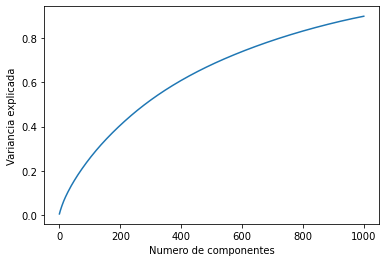

In [23]:
plt.plot(np.cumsum(text_process_pipe['pca'].explained_variance_ratio_))
plt.xlabel('Numero de componentes')
plt.ylabel('Variancia explicada')

## Analise exploratória de cada classe

Os dados possuem 2 classes são elas:

0 - Tweets sobre desastres que são falsos (Não Desastre)

1 - Tweets sobre desastres que são reais (Desastre)

[Text(0, 0, 'Não Desastre'), Text(1, 0, 'Desastre')]

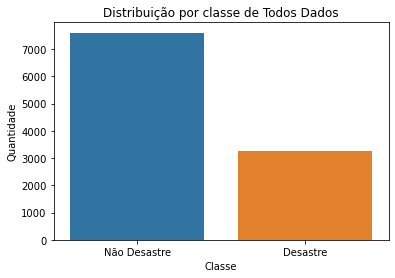

In [24]:
ax = sns.countplot(x='target',data = df)

ax.set_title('Distribuição por classe de Todos Dados')
ax.set_ylabel('Quantidade')
ax.set_xlabel('Classe')
ax.set_xticklabels(["Não Desastre","Desastre"])

Podemos comparar a quantidade de caracteres do tweet dependendo da classe.

Text(0.5, 1.05, 'Distribuição da quantidade de caracteres do tweet por classe')

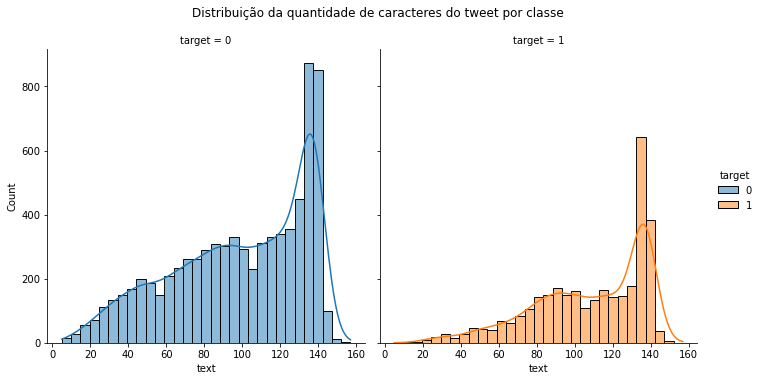

In [25]:
ax = sns.displot(x=df['text'].str.len(),data = df,col='target',hue='target',kde=True)

ax.fig.suptitle('Distribuição da quantidade de caracteres do tweet por classe',y=1.05)

Podemos observar que tweets de não desastre costumam possuir um tamanho maior, porem não achamos importante colocar isso
como feature uma vez que um desastre real teria mais posições nulas em relação ao não real assim sendo percepitivel
aos classificadores.

## Classificadores

Vamos testar os principais classificadores aprendidos durante a disciplina usando a validação cruzada com 5 folds para fazer
a busca de hiperparametros e utilizando como metrica de busca o melhor <b>F1 Macro</b>. Podemos ver o esquema a partir
deste seguinte fluxograma:

In [41]:
from IPython.display import Image

Image(url= "https://scikit-learn.org/stable/_images/grid_search_workflow.png", width=600, height=300)

In [26]:
def test_classifier(classifier,params, X_train,y_train,X_test,y_test):
    if params:
        clf = GridSearchCV(classifier, params, scoring = 'f1_macro',n_jobs = -1,cv=5, verbose=2)
    else:
        clf = classifier

    clf.fit(X_train, y_train)
    
    print(clf.best_params_) if params else print("Done")
    
    y_predicted = clf.predict(X_test)
    
    print(classification_report(y_test, y_predicted))
    ConfusionMatrixDisplay.from_predictions(y_test, y_predicted);
    
    return clf

### Knn

Fitting 5 folds for each of 5 candidates, totalling 25 fits
{'n_neighbors': 3}
              precision    recall  f1-score   support

           0       0.76      0.89      0.82      1522
           1       0.57      0.35      0.43       654

    accuracy                           0.73      2176
   macro avg       0.67      0.62      0.63      2176
weighted avg       0.70      0.73      0.70      2176



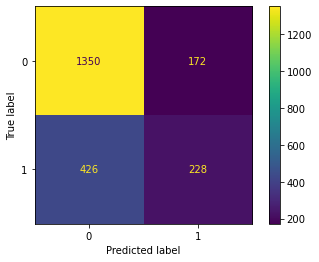

In [27]:
params = {'n_neighbors': [3,5,7,11,13]}

knn = test_classifier(KNeighborsClassifier(),params,X_train,y_train,X_test,y_test)


### Decision Tree

Fitting 5 folds for each of 30 candidates, totalling 150 fits
{'criterion': 'entropy', 'max_depth': 10, 'max_features': 'auto'}
              precision    recall  f1-score   support

           0       0.74      0.87      0.80      1522
           1       0.49      0.29      0.36       654

    accuracy                           0.69      2176
   macro avg       0.61      0.58      0.58      2176
weighted avg       0.66      0.69      0.67      2176



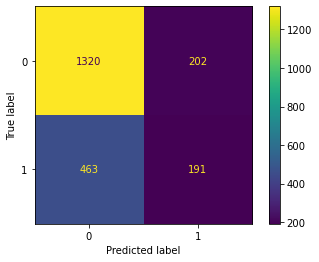

In [28]:
params = {'criterion':['gini','entropy'],
          'max_depth':[None,5,10,50,100],
          'max_features':["auto", "sqrt", "log2"]}

dt = test_classifier(DecisionTreeClassifier(),params,X_train,y_train,X_test,y_test)

In [29]:
dot_data = export_graphviz(dt.best_estimator_, out_file=None,
                     filled=True, rounded=True,  
                     special_characters=True)

graph = graphviz.Source(dot_data)  
#graph.render("dt-vis",view = True)
#graph

### SVM

Fitting 5 folds for each of 1 candidates, totalling 5 fits
{'C': 100, 'gamma': 0.01, 'kernel': 'rbf', 'probability': True}
              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1522
           1       0.60      0.46      0.52       654

    accuracy                           0.75      2176
   macro avg       0.70      0.66      0.67      2176
weighted avg       0.73      0.75      0.74      2176



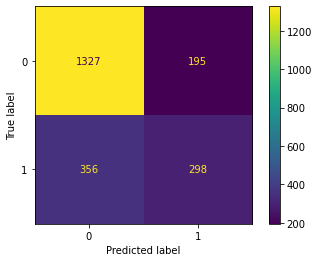

In [30]:
from sklearn.svm import SVC
'''
param_svm = {'C': [0.1,1, 10, 100],
             'gamma': [1,0.1,0.01,0.001],
             'kernel': ['rbf']}
'''
#Foi feita a busca com os parametros acima, para não ficar demorando muito oq deu melhor coloquei aqui
param_svm = {'C': [100],
             'gamma': [0.01],
             'kernel': ['rbf'],
             'probability': [True]}
svm = test_classifier(SVC(),param_svm, X_train,y_train,X_test,y_test)

## Junções classificadores

### Random Forest

Fitting 5 folds for each of 18 candidates, totalling 90 fits
{'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 10}
              precision    recall  f1-score   support

           0       0.74      0.90      0.82      1522
           1       0.55      0.28      0.37       654

    accuracy                           0.72      2176
   macro avg       0.65      0.59      0.59      2176
weighted avg       0.69      0.72      0.68      2176



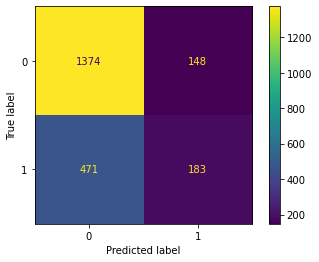

In [31]:
from sklearn.ensemble import RandomForestClassifier

params = {
    'n_estimators': [10, 100,1000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'criterion' :['gini', 'entropy']
}

rf = test_classifier(RandomForestClassifier(),params,X_train,y_train,X_test,y_test)

### Boosting

Done
              precision    recall  f1-score   support

           0       0.75      0.83      0.79      1522
           1       0.49      0.37      0.42       654

    accuracy                           0.69      2176
   macro avg       0.62      0.60      0.60      2176
weighted avg       0.67      0.69      0.68      2176



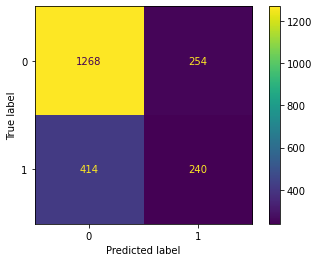

In [32]:
from sklearn.ensemble import AdaBoostClassifier

params_boost_dt = dt.best_params_
dt_b=DecisionTreeClassifier(criterion=params_boost_dt['criterion'],max_depth=params_boost_dt['max_depth'],max_features=params_boost_dt['max_features'])
boost = test_classifier(AdaBoostClassifier(base_estimator=dt_b, n_estimators=50, learning_rate=1), None,X_train,y_train,X_test,y_test)

### Bagging

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   6 | elapsed:    2.8s remaining:    5.7s
[Parallel(n_jobs=6)]: Done   3 out of   6 | elapsed:    3.1s remaining:    3.1s
[Parallel(n_jobs=6)]: Done   4 out of   6 | elapsed:    3.5s remaining:    1.7s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:    4.3s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:    4.3s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Done


[Parallel(n_jobs=6)]: Done   2 out of   6 | elapsed:   12.5s remaining:   25.2s
[Parallel(n_jobs=6)]: Done   3 out of   6 | elapsed:   13.0s remaining:   13.0s
[Parallel(n_jobs=6)]: Done   4 out of   6 | elapsed:   13.2s remaining:    6.5s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:   19.0s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:   19.0s finished


              precision    recall  f1-score   support

           0       0.76      0.90      0.82      1522
           1       0.59      0.35      0.44       654

    accuracy                           0.73      2176
   macro avg       0.68      0.62      0.63      2176
weighted avg       0.71      0.73      0.71      2176



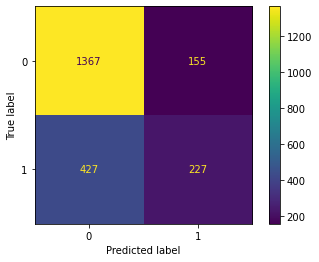

In [33]:
from sklearn.ensemble import BaggingClassifier

knn_bag = KNeighborsClassifier(n_neighbors=knn.best_params_['n_neighbors'])
bag = test_classifier(BaggingClassifier(base_estimator=knn_bag, n_estimators=20, verbose=10, n_jobs=6), None, X_train,y_train,X_test,y_test)

# Resultados
Podemos analisar a partir do gráfico ROC, que o classificador que trouxe mais resultado



## Comparando os classificadores binarios com a curva ROC

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   6 | elapsed:   12.9s remaining:   25.8s
[Parallel(n_jobs=6)]: Done   3 out of   6 | elapsed:   13.2s remaining:   13.2s
[Parallel(n_jobs=6)]: Done   4 out of   6 | elapsed:   15.0s remaining:    7.4s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:   21.3s remaining:    0.0s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:   21.3s finished


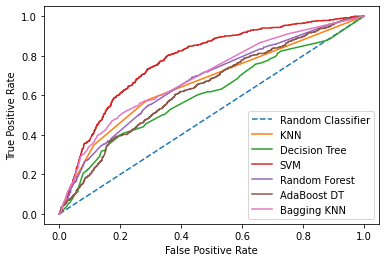

In [34]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

eq_probs = [0 for _ in range(len(y_test))] #Classificador equiprovavel , classifica com 50% de chance
eq_fpr , eq_tpr , _ = roc_curve(y_test,eq_probs)
plt.plot(eq_fpr,eq_tpr,linestyle='--',label = "Random Classifier")

classifiers = [knn,dt,svm,rf,boost,bag]
label = ["KNN","Decision Tree","SVM","Random Forest","AdaBoost DT","Bagging KNN"]
for classifier,label in zip(classifiers,label):
    class_probs = classifier.predict_proba(X_test)
    class_probs = class_probs[:,1] #apenas a chance de classificar a classe positiva

    class_fpr , class_tpr , _ = roc_curve(y_test,class_probs)
    plt.plot(class_fpr,class_tpr,label = label)



plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()

plt.show()



# Conclusões e discussões